# Suggestion engine of UCDs based on common metadata descriptors

Unified Content Descriptors (UCDs) are machine-level descriptions of astronomical data. 
In astronomical data tables, together with columns name, description, and data type, they compose the set of metadata used to describe the content (_i.e._, data) of a dataset.
Whereas column name and description are free text components -- meaning any set of words of the (english) vocabulary can be used to name and describe the data of columns in a data table --, UCDs compose a minimalist set of words (or _atoms_) arranged under a specific set of rules (grammar, if you will).
UCDs are one of the results of the semmantics working group of the International Virtual Observatory Alliance (IVOA) used in any of the Virtual Observatory (VO) data resources.

For example, a column of a (VO) catalog (_table_ in astronomical jargon) providing external URL for each of the elements of the table may be called '`access_url`' with a description "`URL used to access (download) dataset`" would have a UCD '`meta.ref.url`' (with a datatype '`string`').
On one hand, the (english) high-level _description_ of the column -- or even the _name_ -- states clearly to a human what is the content in it. On the other hand, a machine (_i.e._, a software) would have a hard time "understanding" the (human) description. There is where UCDs play their role: properly set, a machine can understand that `meta.ref.url` contains some _meta_ information (non astrophysical quantity) _refering_ to another resource that happens to be an _url_.

The full extent of UCD explanation, vocabulary and grammar, can be seen at http://www.ivoa.net/documents/latest/UCDlist.html and associated documents. In section Data of this document I present other examples of such metadata set.

Although the UCD vocabulary is relatively small and the grammar imposes clear logical rules, data providers (specially newcomers) may have a hard, time-consuming experience in doing it -- much like choosing the keywords for a scientific paper: we know the words but representing the content of the article in a handful of logically conected key-words demands some level of biblioteconomy.

The goal of this note is to apply machine learning (ML) techniques to help the owner of a dataset (_i.e._, catalog) in the process of filling its metadata fields, in particular the UCD field.
To do so, we will using natural language understanding to clean and normalize the data so that we can feed them to ML algorithms.
We will a couple of commonly used ML algorithms -- Support Vector Machines (SVM) and Naive Bayes -- to test our predictive hypothesis.
The data we going to use relate to VO Simple Conesearch Services (SCS), which provide catalogs of astronomical objects (galaxies, stars, planets) of the any, non-specific, content.

In [1]:
def read_columns(config,parameter):
    '''
    Return list of 'parameter' from sections in 'config'
    '''
    sections = list(config.keys())
    sections.sort()
    return [ config[s].get(parameter) for s in sections ]


def read_columns_name(config):
    '''
    Return "clean" 'columns' (names) from 'config'
    
    "clean" means clean from '0-9a-zA-Z+-/*.' characters
    '''
    import re
    name_columns = read_columns(config,'columns')
    out = []
    for columns in name_columns:
        blk = []
        for i,column in enumerate(columns):
            clean_column = re.sub('[^0-9a-zA-Z\+\-\/\*\.]',' ',column).strip()
            blk.append(clean_column)
        out.append(blk)
    return out

def read_columns_description(config):
    '''
    Return "clean" 'descriptions' from 'config'
    
    "clean" means clean from '0-9a-zA-Z ' characters
    '''
    import re
    desc_columns = read_columns(config,'descriptions')
    out = []
    nil = []
    for columns in desc_columns:
        blk = []
        for i,column in enumerate(columns):
            try:
                clean_column = re.sub('[^0-9a-zA-Z ]','',column).strip()
#                 clean_column = re.sub(string.punctuation,'',column).strip()
            except Exception as e:
                nil.append((i,column))
                clean_column = ''
            blk.append(clean_column)
        out.append(blk)
    print("{:d} empty columns".format(len(nil)))
    return out

def read_columns_ucd(config):
    '''
    Return "primary" 'ucds' from 'config'
    
    "primary" means primary ucd words
    '''
    ucd_columns = read_columns(config,'ucds')
    out = []
    for columns in ucd_columns:
        blk = []
        for i,column in enumerate(columns):
            primary_ucd = column.split(';')[0]
            blk.append(primary_ucd)
#             blk.append(column)
        out.append(blk)
    return out

def remove_empty_pairs(ucds, other):
    '''
    Remove ucds/other pairs when 'other' is empty
    '''
    assert len(ucds) == len(other)
    ucds_clean = ucds[:]
    other_clean = other[:]
    empty_ucd_indexes = [i for i,u in enumerate(ucds) if u.lower() == "none" or u.strip() == '']
    print("Number or 'none' UCDs:",len(empty_ucd_indexes))
    empty_other_indexes = [i for i,o in enumerate(other) if o.lower() == "none" or o.strip() == '']
    print("Number or 'none' columns:",len(empty_other_indexes))
    empty_indexes = empty_ucd_indexes + empty_other_indexes
    empty_indexes.sort(reverse=True)
    for i in empty_indexes:
        ucds_clean.pop(i)
        other_clean.pop(i)
    return ucds_clean,other_clean

## Data

We are going to use VO conesearch catalogs (SCS) metadata from the [Vizier](https://vizier.u-strasbg.fr/viz-bin/VizieR) laboratory as they provide a curated set of resources.

In [2]:
with open('data/radio/CATALOGS.json','r') as f:
    import json
    config = json.load(f)

print("The number of catalog metadata sets we are going to use:",len(config))

The number of catalog metadata sets we are going to use: 1367


In [3]:
print("Example of metadata sets:\n")

# from random import shuffle
# keys = list(config.keys())
# shuffle(keys)

import json
for k in config.keys():
    print(json.dumps(config[k], indent=4))
    break

Example of metadata sets:

{
    "title": "CSIRO ASKAP Science Data Archive Cone Search Service",
    "url": "https://casda.csiro.au/casda_vo_tools/scs/obscore?",
    "ivoid": "ivo://au.csiro/casda/scs",
    "creators": [
        "CSIRO"
    ],
    "description": "Cone search service for querying catalogues from ASKAP radio astronomy observations",
    "columns": [
        "obs_id",
        "access_url",
        "target_name",
        "s_ra",
        "s_dec"
    ],
    "ucds": [
        "ID_MAIN",
        "meta.ref.url",
        "meta.id;src",
        "POS_EQ_RA_MAIN",
        "POS_EQ_DEC_MAIN"
    ],
    "units": [
        "None",
        "None",
        "None",
        "deg",
        "deg"
    ],
    "descriptions": [
        "Observation ID",
        "URL used to access (download) dataset",
        "Astronomical object observed, if any",
        "Central right ascension, ICRS",
        "Central declination, ICRS"
    ]
}


In [4]:
desc_columns = read_columns_description(config)

descriptions = [ d for desc in desc_columns for d in desc ]
len(descriptions)

171 empty columns


24511

In [5]:
descriptions[:30]

['Source Designation',
 'AT20G Identification Murphy et al2010MNRAS4022403M',
 'Right Ascension',
 'Declination',
 'Measured 148GHz Flux Density mJy',
 'Deboosted 148GHz Flux Density mJy',
 '',
 'ACTS Source Designation ACTS JHHMMSSDDMMSS',
 'Right Ascension',
 'Declination',
 'Deboosted Flux Density at 148 GHz',
 'Negative Error on Deboosted Flux Density at 148 GHz',
 'Positive Error on Deboosted Flux Density at 148 GHz',
 'Deboosted Flux Density at 218 GHz',
 'Negative Error on Deboosted Flux Density at 218 GHz',
 'Positive Error on Deboosted Flux Density at 218 GHz',
 '',
 'Source Designation',
 'Right Ascension',
 'Declination',
 'Error in Right Ascension',
 'Error in Declination',
 'Flux Density at 20 cm',
 'Error in Flux Density at 20 cm',
 'Integrated Flux Density at 20 cm',
 'Error in Integrated Flux Density at 20 cm',
 '',
 'Sequential Identification Number for Each Radio Source in Catalog',
 'AEGIS20 Source Identifier',
 'Integrated 20cm Flux Density']

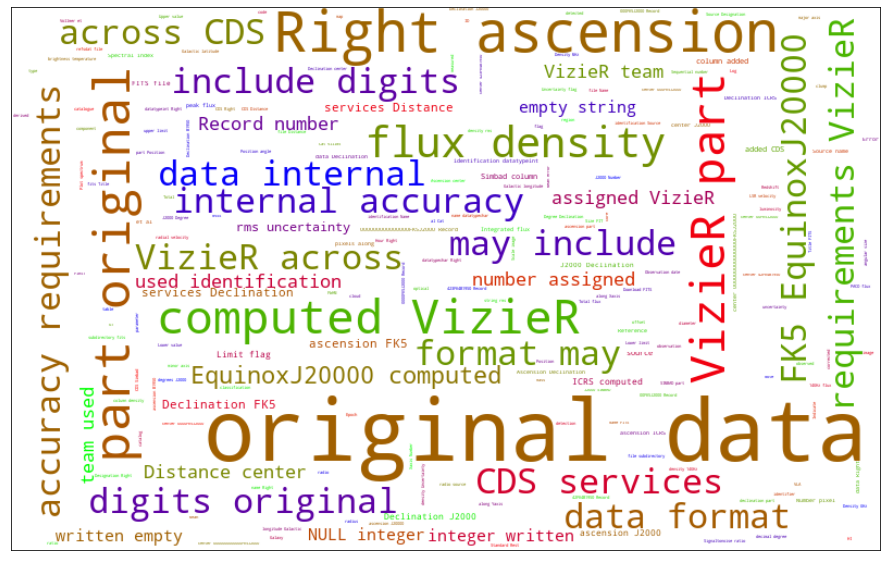

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(width=800, height=500, relative_scaling=1, colormap='brg', background_color='white')
wc.generate('\n'.join(descriptions))

fig,ax = plt.subplots()
fig.set_size_inches(16,10)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(wc, interpolation='bilinear')

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

stopwords = ['vizier','data','original']
stopwords.extend(stop_words.ENGLISH_STOP_WORDS)

VECTORIZER = CountVectorizer(stop_words=stopwords)
# VECTORIZER = CountVectorizer(token_pattern='\\b^\D\\w+\\b', analyzer='word', stop_words=stopwords)

docs = VECTORIZER.fit_transform(descriptions)

features = VECTORIZER.get_feature_names()

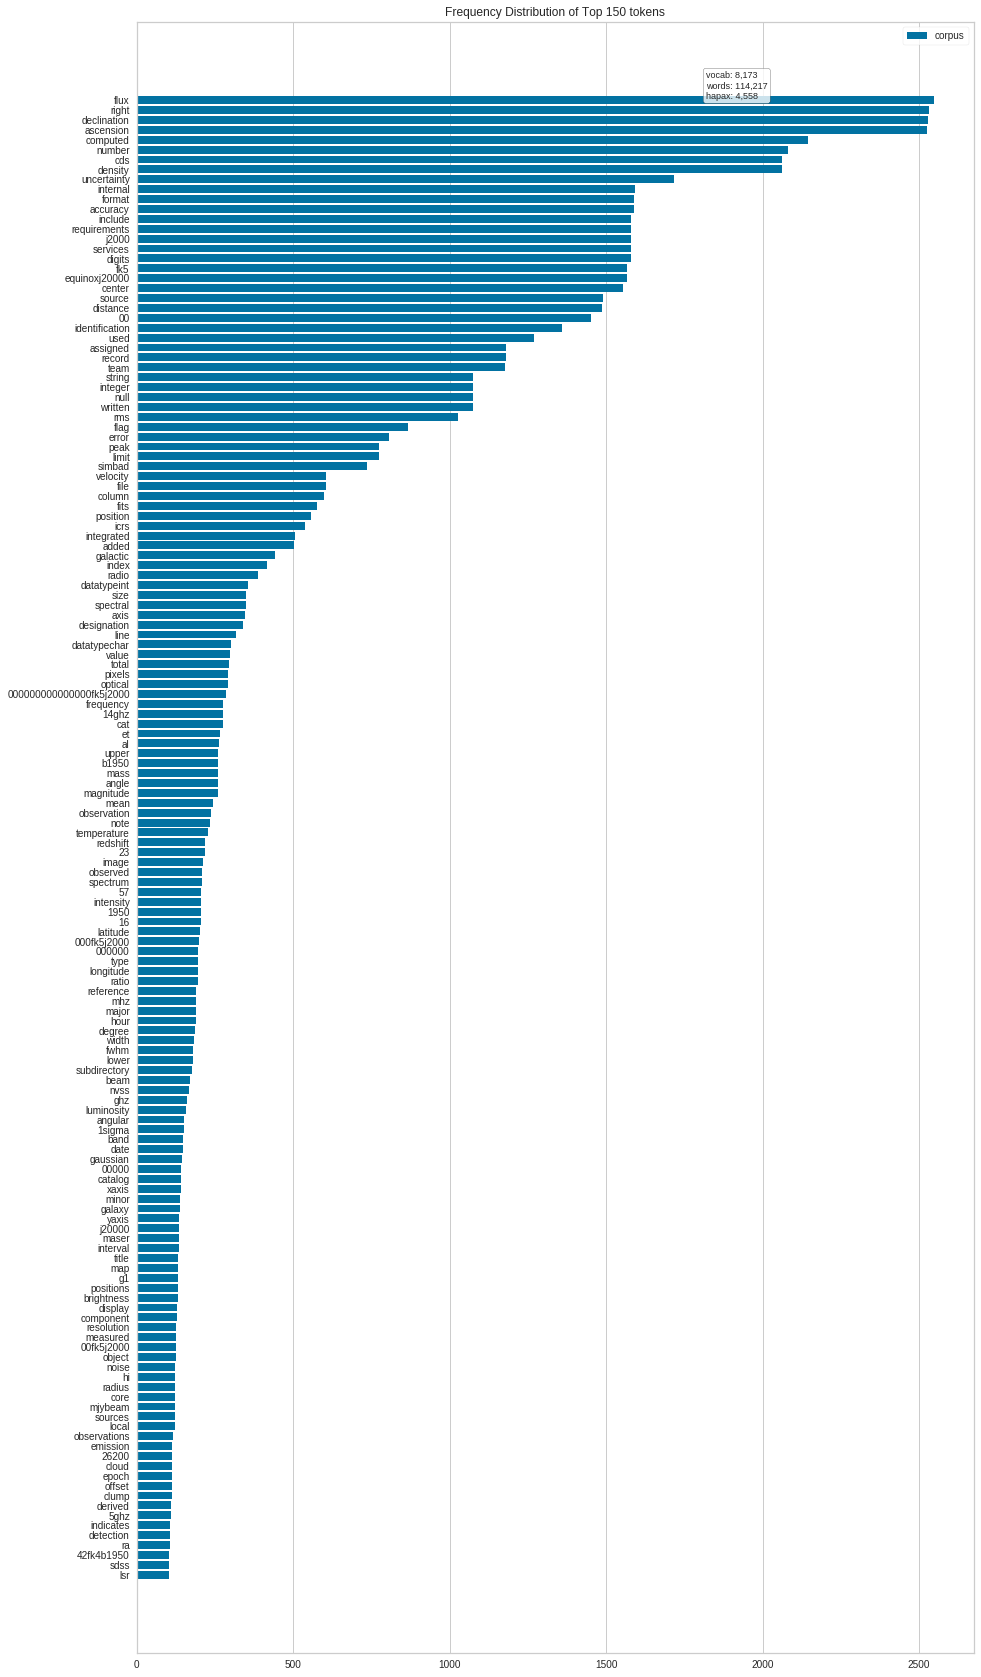

In [8]:
from yellowbrick.text import FreqDistVisualizer

fig,ax = plt.subplots()
fig.set_size_inches(15,30)

visualizer = FreqDistVisualizer(features=features, ax=ax, n=150)
visualizer.fit(docs)
visualizer.poof()

In [9]:
ucd_columns = read_columns_ucd(config)

In [10]:
target_ucd = [ u for ucds in ucd_columns for u in ucds ]
print(len(target_ucd))

24511


Now we map the UCDs to numerical values.

In [11]:
d_ucd2id = { u:i for i,u in enumerate(set(target_ucd)) }
d_id2ucd = { d_ucd2id[u]:u for u in d_ucd2id }
target_id = [ d_ucd2id[u] for u in target_ucd ]
assert len(target_ucd) == len(target_id)

Scikit-learn provides a set of tools to transform the text data into numerical values, where the values are weighted according to their frequency as well as normalized. 

Counting and weighting of terms is important to consider for their relevance, words that are common to many texts get a lower weight as they don't really distinguish as feature within the data. This process is done by the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (frequency counter) and [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) (weighting).

In [12]:
## Pipeline
# Naive Bayes

def MNB(features, targets, use_idf=True):
    # Multinomial Naive Bayes
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.feature_extraction.text import TfidfTransformer
#     from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.pipeline import Pipeline

    text_clf_nb = Pipeline([('vect', VECTORIZER),
                        ('tfidf', TfidfTransformer(use_idf=use_idf)),
                        ('clf', MultinomialNB()),
    ])
    text_clf_nb = text_clf_nb.fit(features,targets)
    return text_clf_nb


def CNB(features, targets, use_idf=True):
    # Complement Naive Bayes
    from sklearn.naive_bayes import ComplementNB
    from sklearn.feature_extraction.text import TfidfTransformer
#     from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.pipeline import Pipeline

    text_clf_nb = Pipeline([('vect', VECTORIZER),
                        ('tfidf', TfidfTransformer(use_idf=use_idf)),
                        ('clf', ComplementNB()),
    ])
    text_clf_nb = text_clf_nb.fit(features,targets)
    return text_clf_nb


def best_prediction(classifier):
    return lambda w:d_id2ucd.get(classifier.predict([w])[0])


def top_predictions(classifier):
    def probs(text):
        probs = classifier.predict_proba([text]).flatten()
        indxs = probs.argsort()
        return [(d_id2ucd.get(i),probs[i]) for i in indxs[-3:]][::-1]
    return probs


def print_predict(predicted):
    for u,p in predicted:
        print('{} : {:.5f}'.format(u,p))


def test_evaluate(classifier, features, targets, test_size=0.2):
    from sklearn.model_selection import train_test_split
    import pandas as pd

    assert classifier.lower() in ('mnb','cnb')

    x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=test_size)
    
    if classifier.lower() == 'mnb':
        text_clf_nb = MNB(x_train,y_train)
    else:
        text_clf_nb = CNB(x_train,y_train)
    
    predicted = [d_id2ucd[i] for i in text_clf_nb.predict(x_test)]
    assert len(predicted)==len(y_test)

    df_eval = pd.DataFrame([(predicted[i],d_id2ucd[y_test[i]],x_test[i]) 
                            for i in range(len(y_test))], 
                           columns=['predicted','truth','description'])
    return df_eval,(x_train, x_test, y_train, y_test)

## Classifying column descriptions

In [13]:
mnb_desc = MNB(descriptions, target_id)
mnb_desc_best_predict = best_prediction(mnb_desc)
mnb_desc_top_predicts = top_predictions(mnb_desc)

In [14]:
mnb_desc_best_predict('magnitude')

'phot.mag'

In [15]:
p = mnb_desc_top_predicts('magnitude')
print_predict(p)

phot.mag : 0.35774
stat.error : 0.12915
phot.flux.density : 0.12415


In [16]:
df_eval,X = test_evaluate('mnb', descriptions, target_id, 0.2)

sum(df_eval.predicted == df_eval.truth)/len(df_eval)

0.6810116255353865

In [17]:
cnb_desc = CNB(descriptions, target_id)
cnb_desc_best_predict = best_prediction(cnb_desc)
cnb_desc_top_predicts = top_predictions(cnb_desc)

In [18]:
cnb_desc_best_predict('magnitude')

'phot.mag'

In [19]:
p = cnb_desc_top_predicts('magnitude')
print_predict(p)

phot.mag : 0.01266
phys.magAbs : 0.00305
None : 0.00292


In [20]:
df_eval,X = test_evaluate('cnb', descriptions, target_id, 0.2)

_match = df_eval.predicted == df_eval.truth
_match.sum()/len(df_eval)

0.7497450540485417

In [21]:
import difflib
def score_diff_ucds(df_row):
    p = df_row['predicted']
    t = df_row['truth']
    score = difflib.SequenceMatcher(None, p, t).ratio()
    return 1 - score

df_eval['score'] = df_eval.apply(score_diff_ucds, axis=1)

In [22]:
def highlight_mismatch(s):
    bg = 'background-color: #ff944d' if s['predicted'] != s['truth'] else ''
    return [bg]*len(s)

df_styled = df_eval.style.apply(highlight_mismatch, axis=1).bar(subset=['score'], align='mid', color=['#d65f5f'])
df_styled